In [ ]:
# Moving Horizon Estimation

This notebook processes battery cycling data, calculates aging factors, applies Moving Horizon Estimation (MHE) with Optuna optimization, and visualizes the results.

## Sections:
1. **Imports and Constants** - Libraries and global constants.
2. **Utility Functions** - General helper functions.
3. **Data Extraction Functions** - Extract data from .mat files.
4. **Aging Factor Calculations** - Compute temperature, SOC, and DOD factors.
5. **Battery Processing** - Process battery data and save results.
6. **MHE Optimization Functions** - Optimize and apply MHE with Optuna.
7. **Error Calculation** - Calculates RMSE and MAPE.
8. **Visualization Functions** - Plotting utilities.
9. **Main Execution** - Run the analysis for a specific battery.

## 1. Imports and Constants

In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from datetime import datetime, timedelta
import optuna
from scipy.optimize import minimize

# Constants
NOMINAL_CAPACITY = 2.0  # Ah
AGING_SCALING_CONSTANT = 0.4

# Aging Factors Coefficients
TEMP_FACTOR_COEFFS = {'a': 1881.3, 'b': 6.0449}
SOC_FACTOR_COEFFS = {'a': 0.00285, 'b': 0.228, 'c': 5.273}
DOD_FACTOR_COEFFS = {'a': 2.15e-3, 'b': 1.5547e-3, 'c': 1.03e-3}
DATASET_FOLDER = 'battery_data'

## 2. Utility Functions

In [2]:
def load_mat_file(dataset_folder, battery_name):
    """Load a .mat file for a given battery."""
    mat_path = os.path.join(dataset_folder, f"{battery_name}.mat")
    return loadmat(mat_path)

def parse_datetime(row_time):
    """Parse datetime from a row of time data."""
    return datetime(
        int(row_time[0]), int(row_time[1]), int(row_time[2]),
        int(row_time[3]), int(row_time[4])
    ) + timedelta(seconds=int(row_time[5]))

def save_dataframe(df, path):
    """Save a DataFrame to a CSV file and print the path."""
    df.to_csv(path, index=False)
    print(f"Data saved to: {path}")

## 3. Data Extraction Functions

In [3]:
def extract_discharge_data(mat, battery_name):
    """Extract discharge data from a .mat file."""
    discharge_data, capacity_data = [], []
    cycle_counter = 1

    for cycle in mat[battery_name][0, 0]['cycle'][0]:
        if cycle['type'][0] == 'discharge':
            ambient_temp = cycle['ambient_temperature'][0][0]
            datetime_stamp = parse_datetime(cycle['time'][0])
            data = cycle['data'][0][0]
            capacity = data['Capacity'][0][0]
            soh = (capacity / NOMINAL_CAPACITY) * 100

            for i in range(len(data['Voltage_measured'][0])):
                discharge_data.append([
                    cycle_counter, ambient_temp, datetime_stamp, capacity, soh,
                    data['Voltage_measured'][0][i], data['Current_measured'][0][i],
                    data['Temperature_measured'][0][i], data['Current_load'][0][i],
                    data['Voltage_load'][0][i], data['Time'][0][i]
                ])

            capacity_data.append([cycle_counter, ambient_temp, datetime_stamp, capacity, soh])
            cycle_counter += 1

    discharge_df = pd.DataFrame(discharge_data, columns=[
        'cycle', 'ambient_temperature', 'datetime', 'capacity', 'soh',
        'voltage_measured', 'current_measured', 'temperature_measured',
        'current', 'voltage', 'time'
    ])
    capacity_df = pd.DataFrame(capacity_data, columns=[
        'cycle', 'ambient_temperature', 'datetime', 'capacity', 'soh'
    ])

    return discharge_df, capacity_df

def extract_charge_data(mat, battery_name):
    """Extract charge data from a .mat file."""
    charge_data = []
    cycle_counter = 1

    for cycle in mat[battery_name][0, 0]['cycle'][0]:
        if cycle['type'][0] == 'charge':
            ambient_temp = cycle['ambient_temperature'][0][0]
            datetime_stamp = parse_datetime(cycle['time'][0])
            data = cycle['data'][0][0]

            for i in range(len(data['Voltage_measured'][0])):
                charge_data.append([
                    cycle_counter, ambient_temp, datetime_stamp,
                    data['Voltage_measured'][0][i], data['Current_measured'][0][i],
                    data['Temperature_measured'][0][i], data['Current_charge'][0][i],
                    data['Voltage_charge'][0][i], data['Time'][0][i]
                ])
            cycle_counter += 1

    charge_df = pd.DataFrame(charge_data, columns=[
        'cycle', 'ambient_temperature', 'datetime',
        'voltage_measured', 'current_measured', 'temperature_measured',
        'current', 'voltage', 'time'
    ])

    return charge_df

## 4. Aging Factor Calculations

In [4]:
def factor_temperature(temp_celsius):
    """Calculate temperature aging factor."""
    temp_kelvin = temp_celsius + 273.15
    if temp_kelvin >= 293.15:
        return np.exp(-TEMP_FACTOR_COEFFS['a'] / temp_kelvin + TEMP_FACTOR_COEFFS['b'])
    return 1.0

def factor_soc(soc_mean):
    """Calculate SOC aging factor."""
    return (SOC_FACTOR_COEFFS['a'] * soc_mean ** 2 -
            SOC_FACTOR_COEFFS['b'] * soc_mean + SOC_FACTOR_COEFFS['c'])

def factor_dod(dod):
    """Calculate DOD aging factor."""
    return DOD_FACTOR_COEFFS['a'] * np.exp(DOD_FACTOR_COEFFS['b'] * dod) + DOD_FACTOR_COEFFS['c']

## 5. Battery Processing

In [5]:
def process_battery(dataset_folder, battery_name, battery_params):
    """Process battery data and calculate aging metrics."""
    mat = load_mat_file(dataset_folder, battery_name)

    # Extract and save cycling data
    discharge_df, capacity_df = extract_discharge_data(mat, battery_name)
    charge_df = extract_charge_data(mat, battery_name)
    cycling_df = pd.concat([charge_df, discharge_df]).sort_values(['cycle', 'time'])
    cycling_path = os.path.join(dataset_folder, f"NASA_cycle_dataset_{battery_name}.csv")
    save_dataframe(cycling_df, cycling_path)

    # Save capacity data
    capacity_path = os.path.join(dataset_folder, f"capacity_soh_{battery_name}.csv")
    save_dataframe(capacity_df, capacity_path)

    # Calculate macro aging metrics
    ambient_temp = battery_params[battery_name]['ambient_temp_celsius']
    discharge_df['soc'] = (discharge_df['capacity'] / NOMINAL_CAPACITY) * 100
    discharge_df['temperature_measured'] = discharge_df['temperature_measured'].fillna(ambient_temp)

    macro_metrics = discharge_df.groupby('cycle').agg({
        'soc': lambda x: x.mean() / 100,
        'temperature_measured': 'mean'
    }).rename(columns={'soc': 'soc_mean', 'temperature_measured': 'cell_temp_mean_celsius'}).reset_index()

    macro_metrics['DOD'] = discharge_df.groupby('cycle')['soc'].agg(lambda x: (x.max() - x.min()) / 100).values
    macro_metrics['p_cyc'] = discharge_df.groupby('cycle')['soc'].agg(lambda x: x.max() / 100).values
    
    macro_metrics['capacity_loss_per_cycle'] = macro_metrics.apply(
        lambda row: factor_temperature(row['cell_temp_mean_celsius']) *
                    factor_soc(row['soc_mean']) * factor_dod(row['DOD']) * AGING_SCALING_CONSTANT, axis=1
    )

    macro_metrics['cumulative_capacity_loss'] = macro_metrics['capacity_loss_per_cycle'].cumsum().clip(upper=NOMINAL_CAPACITY)
    macro_metrics['Final_cyclic_aging'] = ((NOMINAL_CAPACITY - macro_metrics['cumulative_capacity_loss']) / NOMINAL_CAPACITY) * 100

    macro_df = macro_metrics.merge(capacity_df[['cycle', 'soh']], on='cycle', how='left')
    macro_df.rename(columns={'soh': 'ground_truth_soh'}, inplace=True)

    # Save macro aging data
    macro_path = os.path.join(dataset_folder, f"macro_aging_{battery_name}.csv")
    save_dataframe(macro_df, macro_path)

    # Verify output
    print(f"Columns in macro_df for {battery_name}: {macro_df.columns.tolist()}")
    print(macro_df[['cycle', 'Final_cyclic_aging', 'ground_truth_soh']].head())

    return macro_df

## 6. MHE Optimization Functions

In [6]:
def mhe_objective(trial, macro_df):
    """Objective function for Optuna to optimize MHE window size."""
    num_cycles = len(macro_df)
    window_size = trial.suggest_int('window_size', 3, num_cycles)
    
    scaling_factor = macro_df['ground_truth_soh'].mean() / macro_df['Final_cyclic_aging'].mean()
    macro_df['Final_cyclic_aging_scaled'] = macro_df['Final_cyclic_aging'] * scaling_factor
    
    segment_starts = list(range(0, num_cycles, window_size))
    corrected_soh = []
    
    for start in segment_starts:
        end = min(start + window_size, num_cycles)
        segment_df = macro_df.iloc[start:end]
        predicted_soh_segment = segment_df['Final_cyclic_aging_scaled'].values
        ground_truth_segment = segment_df['ground_truth_soh'].values
        
        def segment_cost(k):
            return np.sum((k * predicted_soh_segment - ground_truth_segment)**2)
        
        result = minimize(segment_cost, 1.0, bounds=[(0.5, 1.5)], method='L-BFGS-B')
        k_opt = result.x[0]
        corrected_soh.extend(k_opt * predicted_soh_segment)
    
    mse = np.mean((np.array(corrected_soh) - macro_df['ground_truth_soh'])**2)
    return mse

def apply_mhe_with_optuna(battery_name, dataset_folder, n_trials=20, input_file_template="macro_aging_{battery}.csv"):
    """Apply MHE with Optuna-optimized window size."""
    input_path = os.path.join(dataset_folder, input_file_template.format(battery=battery_name))
    if not os.path.exists(input_path):
        raise FileNotFoundError(f"Input file {input_path} not found.")
    
    macro_df = pd.read_csv(input_path)
    required_columns = ['cycle', 'Final_cyclic_aging', 'ground_truth_soh']
    missing_cols = [col for col in required_columns if col not in macro_df.columns]
    if missing_cols:
        raise ValueError(f"Input file {input_path} missing columns: {missing_cols}")

    # Optimize window size
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: mhe_objective(trial, macro_df.copy()), n_trials=n_trials)
    best_window_size = study.best_params['window_size']
    print(f"\nBest Window Size for {battery_name}: {best_window_size} (MSE = {study.best_value:.4f})")

    # Apply MHE
    scaling_factor = macro_df['ground_truth_soh'].mean() / macro_df['Final_cyclic_aging'].mean()
    macro_df['Final_cyclic_aging_scaled'] = macro_df['Final_cyclic_aging'] * scaling_factor
    
    num_cycles = len(macro_df)
    segment_starts = list(range(0, num_cycles, best_window_size))
    corrected_soh = []
    local_correction_factors = []
    
    for start in segment_starts:
        end = min(start + best_window_size, num_cycles)
        segment_df = macro_df.iloc[start:end]
        predicted_soh_segment = segment_df['Final_cyclic_aging_scaled'].values
        ground_truth_segment = segment_df['ground_truth_soh'].values
        
        def segment_cost(k):
            return np.sum((k * predicted_soh_segment - ground_truth_segment)**2)
        
        result = minimize(segment_cost, 1.0, bounds=[(0.5, 1.5)], method='L-BFGS-B')
        k_opt = result.x[0]
        local_correction_factors.extend([k_opt] * len(segment_df))
        corrected_soh.extend(k_opt * predicted_soh_segment)
    
    macro_df['Local_Corrected_SOH'] = corrected_soh
    macro_df['Local_Correction_Factor'] = local_correction_factors

    # Save results
    output_file = os.path.join(dataset_folder, f"macro_aging_mhe_optuna_{battery_name}.csv")
    save_dataframe(macro_df, output_file)

    return macro_df, best_window_size

def optimize_mhe_parameters(battery_name, dataset_folder, max_trials_outer=10, max_trials_inner=20, 
                            input_file_template="macro_aging_{battery}.csv"):
    """Optimize MHE parameters including window size, correction factor bounds, and initial guess using Optuna."""
    
    # Load the dataset
    input_path = os.path.join(dataset_folder, input_file_template.format(battery=battery_name))
    if not os.path.exists(input_path):
        raise FileNotFoundError(f"Input file {input_path} not found.")
    
    macro_df = pd.read_csv(input_path)
    required_columns = ['cycle', 'Final_cyclic_aging', 'ground_truth_soh']
    missing_cols = [col for col in required_columns if col not in macro_df.columns]
    if missing_cols:
        raise ValueError(f"Input file {input_path} missing columns: {missing_cols}")

    # Define the outer objective function for optimizing MHE parameters
    def outer_objective(trial):
        lower_bound = trial.suggest_float('lower_bound', 0.1, 0.9)
        upper_bound = trial.suggest_float('upper_bound', 1.1, 2.0)
        if lower_bound >= upper_bound:
            raise optuna.exceptions.TrialPruned()
        initial_guess = trial.suggest_float('initial_guess', lower_bound, upper_bound)
        inner_trials = trial.suggest_int('inner_trials', 5, max_trials_inner)

        def inner_objective(trial, df):
            num_cycles = len(df)
            window_size = trial.suggest_int('window_size', 3, num_cycles)
            
            scaling_factor = df['ground_truth_soh'].mean() / df['Final_cyclic_aging'].mean()
            df['Final_cyclic_aging_scaled'] = df['Final_cyclic_aging'] * scaling_factor
            
            segment_starts = list(range(0, num_cycles, window_size))
            corrected_soh = []
            
            for start in segment_starts:
                end = min(start + window_size, num_cycles)
                segment_df = df.iloc[start:end]
                predicted_soh_segment = segment_df['Final_cyclic_aging_scaled'].values
                ground_truth_segment = segment_df['ground_truth_soh'].values
                
                def segment_cost(k):
                    return np.sum((k * predicted_soh_segment - ground_truth_segment)**2)
                
                result = minimize(segment_cost, initial_guess, bounds=[(lower_bound, upper_bound)], 
                                method='L-BFGS-B')
                k_opt = result.x[0]
                corrected_soh.extend(k_opt * predicted_soh_segment)
            
            mse = np.mean((np.array(corrected_soh) - df['ground_truth_soh'])**2)
            return mse

        inner_study = optuna.create_study(direction='minimize')
        inner_study.optimize(lambda trial: inner_objective(trial, macro_df.copy()), n_trials=inner_trials)
        return inner_study.best_value

    # Run outer optimization
    outer_study = optuna.create_study(direction='minimize')
    outer_study.optimize(outer_objective, n_trials=max_trials_outer)

    # Extract best parameters
    best_params = outer_study.best_params
    best_lower_bound = best_params['lower_bound']
    best_upper_bound = best_params['upper_bound']
    best_initial_guess = best_params['initial_guess']
    best_inner_trials = best_params['inner_trials']
    best_mse = outer_study.best_value

    print(f"\nOptimized Parameters for {battery_name}:")
    print(f"Lower Bound: {best_lower_bound:.4f}")
    print(f"Upper Bound: {best_upper_bound:.4f}")
    print(f"Initial Guess: {best_initial_guess:.4f}")
    print(f"Inner Trials: {best_inner_trials}")
    print(f"Best MSE: {best_mse:.4f}")

    # Apply MHE with optimized parameters
    def apply_best_mhe(df, lower_bound, upper_bound, initial_guess, inner_trials):
        num_cycles = len(df)
        scaling_factor = df['ground_truth_soh'].mean() / df['Final_cyclic_aging'].mean()
        df['Final_cyclic_aging_scaled'] = df['Final_cyclic_aging'] * scaling_factor
        
        # Redefine inner_objective here with the same logic
        def inner_objective(trial, df):
            num_cycles = len(df)
            window_size = trial.suggest_int('window_size', 3, num_cycles)
            
            segment_starts = list(range(0, num_cycles, window_size))
            corrected_soh = []
            
            for start in segment_starts:
                end = min(start + window_size, num_cycles)
                segment_df = df.iloc[start:end]
                predicted_soh_segment = segment_df['Final_cyclic_aging_scaled'].values
                ground_truth_segment = segment_df['ground_truth_soh'].values
                
                def segment_cost(k):
                    return np.sum((k * predicted_soh_segment - ground_truth_segment)**2)
                
                result = minimize(segment_cost, initial_guess, bounds=[(lower_bound, upper_bound)], 
                                method='L-BFGS-B')
                k_opt = result.x[0]
                corrected_soh.extend(k_opt * predicted_soh_segment)
            
            mse = np.mean((np.array(corrected_soh) - df['ground_truth_soh'])**2)
            return mse

        inner_study = optuna.create_study(direction='minimize')
        inner_study.optimize(lambda trial: inner_objective(trial, df.copy()), n_trials=inner_trials)
        best_window_size = inner_study.best_params['window_size']
        
        segment_starts = list(range(0, num_cycles, best_window_size))
        corrected_soh = []
        local_correction_factors = []
        
        for start in segment_starts:
            end = min(start + best_window_size, num_cycles)
            segment_df = df.iloc[start:end]
            predicted_soh_segment = segment_df['Final_cyclic_aging_scaled'].values
            ground_truth_segment = segment_df['ground_truth_soh'].values
            
            def segment_cost(k):
                return np.sum((k * predicted_soh_segment - ground_truth_segment)**2)
            
            result = minimize(segment_cost, initial_guess, bounds=[(lower_bound, upper_bound)], 
                            method='L-BFGS-B')
            k_opt = result.x[0]
            local_correction_factors.extend([k_opt] * len(segment_df))
            corrected_soh.extend(k_opt * predicted_soh_segment)
        
        df['Local_Corrected_SOH'] = corrected_soh
        df['Local_Correction_Factor'] = local_correction_factors
        return df, best_window_size

    # Apply and save results
    macro_df, best_window_size = apply_best_mhe(macro_df, best_lower_bound, best_upper_bound, 
                                                best_initial_guess, best_inner_trials)
    output_file = os.path.join(dataset_folder, f"macro_aging_mhe_optuna_advanced_{battery_name}.csv")
    macro_df.to_csv(output_file, index=False)
    print(f"Best Window Size: {best_window_size}")
    print(f"Results saved to {output_file}")

    return macro_df, best_params



## 7. Error Calculation

In [7]:
def calculate_soh_errors(macro_df, battery_name, print_results=True):
    """
    Calculate RMSE and MAPE between ground truth SOH and MHE-corrected SOH.
    
    Parameters:
    - macro_df: DataFrame containing 'ground_truth_soh' and 'Local_Corrected_SOH'
    - battery_name: Name of the battery (e.g., "B0005")
    - print_results: Boolean to print the results (default: True)
    
    Returns:
    - rmse: Root Mean Squared Error
    - mape: Mean Absolute Percentage Error (in percentage)
    """
    # Check if required columns exist
    required_columns = ['ground_truth_soh', 'Local_Corrected_SOH']
    missing_cols = [col for col in required_columns if col not in macro_df.columns]
    if missing_cols:
        raise ValueError(f"DataFrame missing required columns: {missing_cols}")

    # Extract data
    ground_truth_soh = macro_df['ground_truth_soh'].values
    corrected_soh = macro_df['Local_Corrected_SOH'].values

    # Calculate RMSE
    rmse = np.sqrt(np.mean((ground_truth_soh - corrected_soh) ** 2))

    # Calculate MAPE (avoid division by zero by adding a small epsilon)
    epsilon = 1e-10  # Small value to prevent division by zero
    mape = np.mean(np.abs((ground_truth_soh - corrected_soh) / (ground_truth_soh + epsilon))) * 100

    # Print results if requested
    if print_results:
        print(f"\nError Metrics for Battery {battery_name}:")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAPE: {mape:.4f}%")

    return rmse, mape

## 8. Visualization Functions

In [8]:
def plot_soh(battery_name, macro_df, window_size):
    """Plot SOH comparison."""
    plt.figure(figsize=(12, 8))
    plt.plot(macro_df['cycle'], macro_df['ground_truth_soh'], label='Ground Truth SOH', color='b')
    plt.plot(macro_df['cycle'], macro_df['Final_cyclic_aging_scaled'], label='Final Cyclic Aging (scaled)', color='r')
    plt.plot(macro_df['cycle'], macro_df['Local_Corrected_SOH'], label=f'Local Corrected SOH (Window {window_size})', color='g')
    plt.title(f'MHE SOH Estimation with Optuna for {battery_name}', fontsize=14)
    plt.xlabel('Discharge Cycle', fontsize=12)
    plt.ylabel('SOH (%)', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_correction_factor(battery_name, macro_df, window_size):
    """Plot local correction factor trend."""
    plt.figure(figsize=(12, 8))
    plt.step(macro_df['cycle'], macro_df['Local_Correction_Factor'], label=f'Local Correction Factor (Window {window_size})', color='c', where='post')
    plt.title(f'MHE Correction Factor Trend for {battery_name}', fontsize=14)
    plt.xlabel('Discharge Cycle', fontsize=12)
    plt.ylabel('Correction Factor', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_soh_comparison(macro_df, battery_name, output_folder="battery_data", save_plot=True):
    """
    Plot ground truth SOH, estimated SOH, and MHE-corrected SOH against cycle number.
    
    Parameters:
    - macro_df: DataFrame containing 'cycle', 'ground_truth_soh', 'Final_cyclic_aging_scaled', and 'Local_Corrected_SOH'
    - battery_name: Name of the battery (e.g., "B0005")
    - output_folder: Directory to save the plot (default: "battery_data")
    - save_plot: Boolean to save the plot as a file (default: True)
    """
    # Check if required columns exist
    required_columns = ['cycle', 'ground_truth_soh', 'Final_cyclic_aging_scaled', 'Local_Corrected_SOH']
    missing_cols = [col for col in required_columns if col not in macro_df.columns]
    if missing_cols:
        raise ValueError(f"DataFrame missing required columns: {missing_cols}")

    # Extract data for plotting
    cycles = macro_df['cycle']
    ground_truth_soh = macro_df['ground_truth_soh']
    estimated_soh = macro_df['Final_cyclic_aging_scaled']
    mhe_corrected_soh = macro_df['Local_Corrected_SOH']

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(cycles, ground_truth_soh, label='Ground Truth SOH', color='blue', linewidth=2)
    plt.plot(cycles, estimated_soh, label='Estimated SOH (Scaled)', color='orange', linestyle='--', linewidth=2)
    plt.plot(cycles, mhe_corrected_soh, label='MHE-Corrected SOH', color='green', linestyle='-.', linewidth=2)

    # Add labels and title
    plt.xlabel('Cycle Number')
    plt.ylabel('State of Health (SOH)')
    plt.title(f'SOH Comparison for Battery {battery_name}')
    plt.legend()
    plt.grid(True)

    # Save the plot if requested
    if save_plot:
        output_file = os.path.join(output_folder, f"soh_comparison_{battery_name}.png")
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {output_file}")

    # Display the plot
    plt.show()

## 9. Main Execution


Processing battery: B0005


[I 2025-03-19 08:43:38,412] A new study created in memory with name: no-name-d0d67fb6-8a30-46e1-aa89-0afa8fce5920
[I 2025-03-19 08:43:38,415] A new study created in memory with name: no-name-ed76d6ed-3888-4390-97f8-9469b3de033a
[I 2025-03-19 08:43:38,426] Trial 0 finished with value: 10.912180094562759 and parameters: {'window_size': 119}. Best is trial 0 with value: 10.912180094562759.
[I 2025-03-19 08:43:38,444] Trial 1 finished with value: 7.276113664917195 and parameters: {'window_size': 55}. Best is trial 1 with value: 7.276113664917195.
[I 2025-03-19 08:43:38,460] Trial 2 finished with value: 16.915832568744722 and parameters: {'window_size': 149}. Best is trial 1 with value: 7.276113664917195.
[I 2025-03-19 08:43:38,479] Trial 3 finished with value: 11.638362474344373 and parameters: {'window_size': 102}. Best is trial 1 with value: 7.276113664917195.
[I 2025-03-19 08:43:38,494] Trial 4 finished with value: 27.1524979133132 and parameters: {'window_size': 165}. Best is trial 1 w

Data saved to: battery_data\NASA_cycle_dataset_B0005.csv
Data saved to: battery_data\capacity_soh_B0005.csv
Data saved to: battery_data\macro_aging_B0005.csv
Columns in macro_df for B0005: ['cycle', 'soc_mean', 'cell_temp_mean_celsius', 'DOD', 'p_cyc', 'capacity_loss_per_cycle', 'cumulative_capacity_loss', 'Final_cyclic_aging', 'ground_truth_soh']
   cycle  Final_cyclic_aging  ground_truth_soh
0      1           99.711120         92.824371
1      2           99.421286         92.316362
2      3           99.131861         91.767460
3      4           98.843180         91.763126
4      5           98.555266         91.732275


[I 2025-03-19 08:43:38,512] Trial 5 finished with value: 11.753648594498424 and parameters: {'window_size': 101}. Best is trial 1 with value: 7.276113664917195.
[I 2025-03-19 08:43:38,527] Trial 6 finished with value: 7.784258898716995 and parameters: {'window_size': 57}. Best is trial 1 with value: 7.276113664917195.
[I 2025-03-19 08:43:38,541] Trial 7 finished with value: 12.81683352217461 and parameters: {'window_size': 86}. Best is trial 1 with value: 7.276113664917195.
[I 2025-03-19 08:43:38,560] Trial 8 finished with value: 13.024326790301794 and parameters: {'window_size': 135}. Best is trial 1 with value: 7.276113664917195.
[I 2025-03-19 08:43:38,635] Trial 9 finished with value: 0.5404245811763106 and parameters: {'window_size': 8}. Best is trial 9 with value: 0.5404245811763106.
[I 2025-03-19 08:43:38,707] Trial 10 finished with value: 0.3304350661801294 and parameters: {'window_size': 6}. Best is trial 10 with value: 0.3304350661801294.
[I 2025-03-19 08:43:38,896] Trial 11 f


Optimized Parameters for B0005:
Lower Bound: 0.7310
Upper Bound: 1.7922
Initial Guess: 1.0406
Inner Trials: 18
Best MSE: 0.2238


[I 2025-03-19 08:43:43,855] Trial 9 finished with value: 0.8565995818060108 and parameters: {'window_size': 12}. Best is trial 9 with value: 0.8565995818060108.
[I 2025-03-19 08:43:43,984] Trial 10 finished with value: 0.33386750520867636 and parameters: {'window_size': 5}. Best is trial 10 with value: 0.33386750520867636.
[I 2025-03-19 08:43:44,029] Trial 11 finished with value: 1.0490219451934255 and parameters: {'window_size': 14}. Best is trial 10 with value: 0.33386750520867636.
[I 2025-03-19 08:43:44,240] Trial 12 finished with value: 0.22378002151655546 and parameters: {'window_size': 3}. Best is trial 12 with value: 0.22378002151655546.
[I 2025-03-19 08:43:44,416] Trial 13 finished with value: 0.22378002151655546 and parameters: {'window_size': 3}. Best is trial 12 with value: 0.22378002151655546.
[I 2025-03-19 08:43:44,440] Trial 14 finished with value: 7.391729111221624 and parameters: {'window_size': 63}. Best is trial 12 with value: 0.22378002151655546.
[I 2025-03-19 08:43:

Best Window Size: 3
Results saved to battery_data\macro_aging_mhe_optuna_advanced_B0005.csv

Local Corrected SOH for B0005 (Optimized Parameters):
   cycle  ground_truth_soh  Final_cyclic_aging_scaled  Local_Corrected_SOH  \
0      1         92.824371                 103.780125            92.572192   
1      2         92.316362                 103.478463            92.303108   
2      3         91.767460                 103.177228            92.034405   
3      4         91.763126                 102.876767            92.027105   
4      5         91.732275                 102.577103            91.759044   

   Local_Correction_Factor  
0                 0.892003  
1                 0.892003  
2                 0.892003  
3                 0.894537  
4                 0.894537  
Plot saved to battery_data\soh_comparison_B0005.png


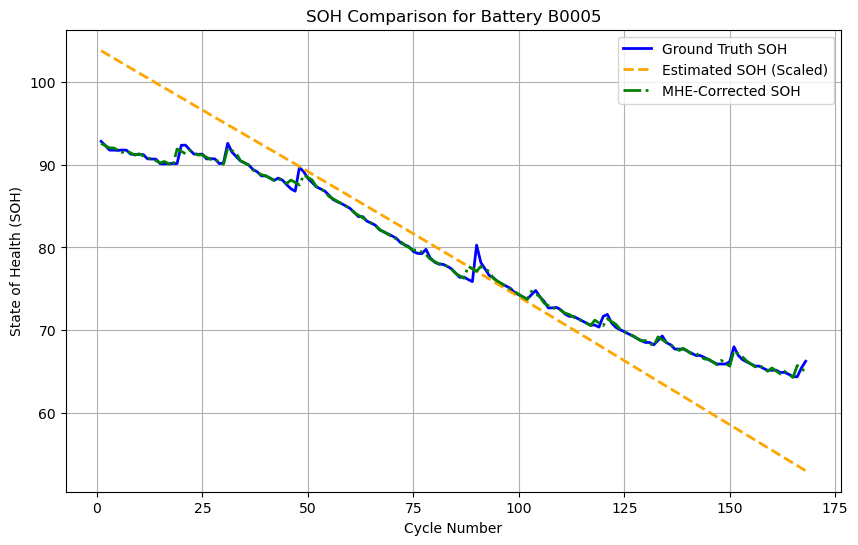


Error Metrics for Battery B0005:
RMSE: 0.4731
MAPE: 0.3057%


In [9]:
import json
import os

# Assuming these functions are defined elsewhere in your script
# from your_script import optimize_mhe_parameters, plot_soh_comparison, calculate_soh_errors

# Define dataset folder (replace with your actual path)
DATASET_FOLDER = "battery_data"

# Load battery parameters
with open("battery_params.json", 'r') as json_file:
    battery_params = json.load(json_file)

# Process battery data (assuming process_battery is defined elsewhere)
battery_name = 'B0005'
print(f"\nProcessing battery: {battery_name}")
macro_df = process_battery(DATASET_FOLDER, battery_name, battery_params)

# Apply MHE with Optuna using the optimized parameters function
macro_df_mhe, best_params = optimize_mhe_parameters(battery_name, DATASET_FOLDER, 
                                                    max_trials_outer=10, max_trials_inner=20)

# Extract best window size from best_params (if needed, though it's also returned by apply_best_mhe internally)
best_window_size = macro_df_mhe.attrs.get('best_window_size', None)  # Optional: store in attrs if desired
if best_window_size is None:
    print("Warning: Best window size not explicitly returned; check optimize_mhe_parameters output.")

# Display results
print(f"\nLocal Corrected SOH for {battery_name} (Optimized Parameters):")
print(macro_df_mhe[['cycle', 'ground_truth_soh', 'Final_cyclic_aging_scaled', 
                    'Local_Corrected_SOH', 'Local_Correction_Factor']].head())

# Visualize results
plot_soh_comparison(macro_df_mhe, battery_name, DATASET_FOLDER)

# Calculate and display error metrics
rmse, mape = calculate_soh_errors(macro_df_mhe, battery_name)

In [10]:
def optimize_global_correction_factor(battery_name, dataset_folder, n_trials=50, 
                                      input_file_template="macro_aging_{battery}.csv"):
    """
    Optimize a global correction factor using Optuna to minimize MSE between corrected and ground truth SOH.
    
    Parameters:
    - battery_name: Name of the battery (e.g., "B0005")
    - dataset_folder: Directory containing the input data
    - n_trials: Number of Optuna trials (default: 50)
    - input_file_template: Template for input file name (default: "macro_aging_{battery}.csv")
    
    Returns:
    - macro_df: DataFrame with the globally corrected SOH
    - best_k_global: The optimized global correction factor
    """
    # Load the dataset
    input_path = os.path.join(dataset_folder, input_file_template.format(battery=battery_name))
    if not os.path.exists(input_path):
        raise FileNotFoundError(f"Input file {input_path} not found.")
    
    macro_df = pd.read_csv(input_path)
    required_columns = ['cycle', 'Final_cyclic_aging', 'ground_truth_soh']
    missing_cols = [col for col in required_columns if col not in macro_df.columns]
    if missing_cols:
        raise ValueError(f"Input file {input_path} missing columns: {missing_cols}")

    # Apply initial scaling factor
    scaling_factor = macro_df['ground_truth_soh'].mean() / macro_df['Final_cyclic_aging'].mean()
    macro_df['Final_cyclic_aging_scaled'] = macro_df['Final_cyclic_aging'] * scaling_factor

    # Define the objective function for Optuna
    def objective(trial):
        k_global = trial.suggest_float('k_global', 0.5, 1.5)  # Range for the global correction factor
        corrected_soh = macro_df['Final_cyclic_aging_scaled'] * k_global
        mse = np.mean((corrected_soh - macro_df['ground_truth_soh']) ** 2)
        return mse

    # Run Optuna optimization
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

    # Extract the best global correction factor
    best_k_global = study.best_params['k_global']
    best_mse = study.best_value

    print(f"\nOptimized Global Correction Factor for {battery_name}:")
    print(f"Best k_global: {best_k_global:.4f}")
    print(f"Best MSE: {best_mse:.4f}")

    # Apply the best global correction factor
    macro_df['Global_Corrected_SOH'] = macro_df['Final_cyclic_aging_scaled'] * best_k_global

    # Save results
    output_file = os.path.join(dataset_folder, f"macro_aging_global_optuna_{battery_name}.csv")
    macro_df.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")

    return macro_df, best_k_global

# Example usage
macro_df_global, best_k_global = optimize_global_correction_factor("B0005", "battery_data", n_trials=50)

[I 2025-03-19 08:46:15,592] A new study created in memory with name: no-name-4e14e95e-6afa-449d-ba39-7d4ad2f11363
[I 2025-03-19 08:46:15,594] Trial 0 finished with value: 480.8885221370798 and parameters: {'k_global': 1.2530634185355958}. Best is trial 0 with value: 480.8885221370798.
[I 2025-03-19 08:46:15,594] Trial 1 finished with value: 259.8380013702611 and parameters: {'k_global': 0.7981375330715439}. Best is trial 1 with value: 259.8380013702611.
[I 2025-03-19 08:46:15,594] Trial 2 finished with value: 284.7269776339845 and parameters: {'k_global': 1.1871303995012534}. Best is trial 1 with value: 259.8380013702611.
[I 2025-03-19 08:46:15,612] Trial 3 finished with value: 642.2690389135021 and parameters: {'k_global': 1.2969421460850004}. Best is trial 1 with value: 259.8380013702611.
[I 2025-03-19 08:46:15,617] Trial 4 finished with value: 433.74032853402815 and parameters: {'k_global': 1.238801232533672}. Best is trial 1 with value: 259.8380013702611.
[I 2025-03-19 08:46:15,621


Optimized Global Correction Factor for B0005:
Best k_global: 0.9877
Best MSE: 30.0466
Results saved to battery_data\macro_aging_global_optuna_B0005.csv


In [11]:
def plot_soh_comparison(macro_df, battery_name, output_folder="battery_data", save_plot=True, 
                        global_df=None):
    required_columns = ['cycle', 'ground_truth_soh', 'Final_cyclic_aging_scaled', 'Local_Corrected_SOH']
    missing_cols = [col for col in required_columns if col not in macro_df.columns]
    if missing_cols:
        raise ValueError(f"DataFrame missing required columns: {missing_cols}")

    cycles = macro_df['cycle']
    ground_truth_soh = macro_df['ground_truth_soh']
    estimated_soh = macro_df['Final_cyclic_aging_scaled']
    mhe_corrected_soh = macro_df['Local_Corrected_SOH']

    plt.figure(figsize=(12, 6))
    plt.plot(cycles, ground_truth_soh, label='Ground Truth SOH', color='blue', linewidth=2)
    plt.plot(cycles, estimated_soh, label='Estimated SOH (Scaled)', color='orange', linestyle='--', linewidth=2)
    plt.plot(cycles, mhe_corrected_soh, label='MHE-Corrected SOH', color='green', linestyle='-.', linewidth=2)

    if global_df is not None and 'Global_Corrected_SOH' in global_df.columns:
        plt.plot(cycles, global_df['Global_Corrected_SOH'], label='Global-Corrected SOH', 
                 color='red', linestyle=':', linewidth=2)

    plt.xlabel('Cycle Number')
    plt.ylabel('State of Health (SOH)')
    plt.title(f'SOH Comparison for Battery {battery_name}')
    plt.legend()
    plt.grid(True)

    if save_plot:
        output_file = os.path.join(output_folder, f"soh_comparison_{battery_name}.png")
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {output_file}")

    plt.show()

Plot saved to battery_data\soh_comparison_B0005.png


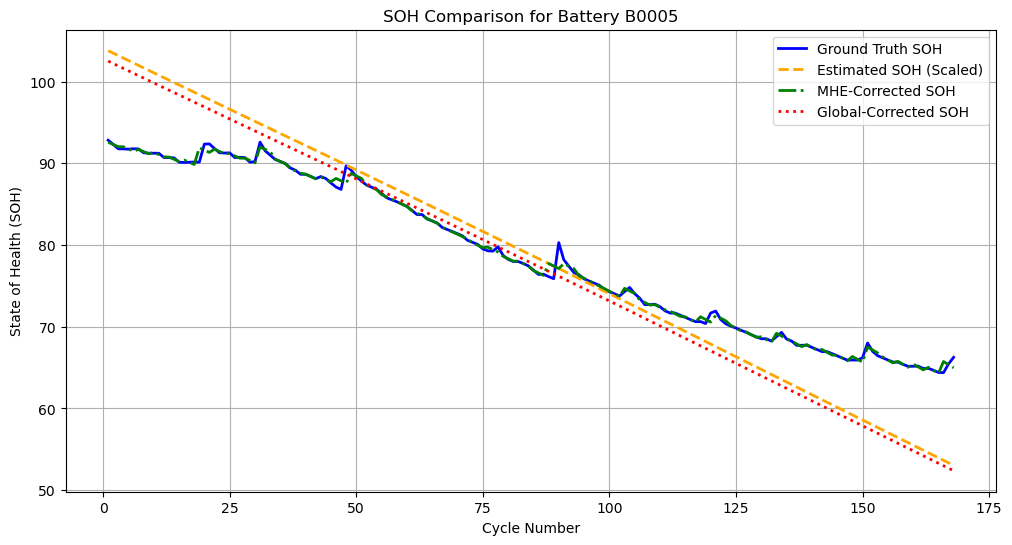

In [12]:
plot_soh_comparison(macro_df_mhe, battery_name, DATASET_FOLDER, global_df=macro_df_global)

In [13]:
import optuna
import numpy as np
import pandas as pd
import os

def optimize_segmented_global_correction(battery_name, dataset_folder, segment_size=30, n_trials=50, 
                                         input_file_template="macro_aging_{battery}.csv"):
    """
    Optimize a global correction factor for each 30-cycle segment using Optuna.
    
    Parameters:
    - battery_name: Name of the battery (e.g., "B0005")
    - dataset_folder: Directory containing the input data
    - segment_size: Number of cycles per segment (default: 30)
    - n_trials: Number of Optuna trials per segment (default: 50)
    - input_file_template: Template for input file name (default: "macro_aging_{battery}.csv")
    
    Returns:
    - macro_df: DataFrame with the segmented globally corrected SOH
    - best_k_globals: List of optimized global correction factors for each segment
    """
    # Load the dataset
    input_path = os.path.join(dataset_folder, input_file_template.format(battery=battery_name))
    if not os.path.exists(input_path):
        raise FileNotFoundError(f"Input file {input_path} not found.")
    
    macro_df = pd.read_csv(input_path)
    required_columns = ['cycle', 'Final_cyclic_aging', 'ground_truth_soh']
    missing_cols = [col for col in required_columns if col not in macro_df.columns]
    if missing_cols:
        raise ValueError(f"Input file {input_path} missing columns: {missing_cols}")

    # Apply initial scaling factor
    scaling_factor = macro_df['ground_truth_soh'].mean() / macro_df['Final_cyclic_aging'].mean()
    macro_df['Final_cyclic_aging_scaled'] = macro_df['Final_cyclic_aging'] * scaling_factor

    # Segment the data into fixed 30-cycle chunks
    num_cycles = len(macro_df)
    segment_starts = list(range(0, num_cycles, segment_size))
    corrected_soh = []
    best_k_globals = []

    # Optimize k_global for each segment
    for start in segment_starts:
        end = min(start + segment_size, num_cycles)
        segment_df = macro_df.iloc[start:end]
        if len(segment_df) == 0:  # Skip empty segments
            continue

        # Define the objective function for this segment
        def objective(trial):
            k_global = trial.suggest_float('k_global', 0.5, 1.5)  # Range for the correction factor
            corrected_soh_segment = segment_df['Final_cyclic_aging_scaled'] * k_global
            mse = np.mean((corrected_soh_segment - segment_df['ground_truth_soh']) ** 2)
            return mse

        # Run Optuna optimization for this segment
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=n_trials)

        # Extract the best k_global for this segment
        best_k_global = study.best_params['k_global']
        best_k_globals.append(best_k_global)
        corrected_soh_segment = segment_df['Final_cyclic_aging_scaled'] * best_k_global
        corrected_soh.extend(corrected_soh_segment)

        print(f"Segment {start}-{end}: Best k_global = {best_k_global:.4f}, MSE = {study.best_value:.4f}")

    # Ensure corrected_soh matches the DataFrame length
    if len(corrected_soh) != len(macro_df):
        raise ValueError(f"Length mismatch: corrected_soh ({len(corrected_soh)}) vs macro_df ({len(macro_df)})")

    # Add the segmented corrected SOH to the DataFrame
    macro_df['Segmented_Global_Corrected_SOH'] = corrected_soh

    # Assign segment-wise correction factors (repeat each k_global for its segment)
    correction_factors = []
    for i, start in enumerate(segment_starts):
        end = min(start + segment_size, num_cycles)
        correction_factors.extend([best_k_globals[i]] * (end - start))
    macro_df['Segmented_Global_Correction_Factor'] = correction_factors

    # Save results
    output_file = os.path.join(dataset_folder, f"macro_aging_segmented_global_optuna_{battery_name}.csv")
    macro_df.to_csv(output_file, index=False)
    print(f"\nResults saved to {output_file}")

    return macro_df, best_k_globals

# Example usage
macro_df_segmented, best_k_globals = optimize_segmented_global_correction("B0005", "battery_data", segment_size=30, n_trials=50)

[I 2025-03-19 08:49:58,800] A new study created in memory with name: no-name-a0554a75-0459-419f-adbd-514775fda48f
[I 2025-03-19 08:49:58,807] Trial 0 finished with value: 1110.1470532602132 and parameters: {'k_global': 1.250396245945645}. Best is trial 0 with value: 1110.1470532602132.
[I 2025-03-19 08:49:58,811] Trial 1 finished with value: 657.0072347569834 and parameters: {'k_global': 1.1729259965184073}. Best is trial 1 with value: 657.0072347569834.
[I 2025-03-19 08:49:58,818] Trial 2 finished with value: 1743.4821317018148 and parameters: {'k_global': 1.3353359061993644}. Best is trial 1 with value: 657.0072347569834.
[I 2025-03-19 08:49:58,818] Trial 3 finished with value: 400.10337947518667 and parameters: {'k_global': 1.1160918543640514}. Best is trial 3 with value: 400.10337947518667.
[I 2025-03-19 08:49:58,818] Trial 4 finished with value: 95.55423083286097 and parameters: {'k_global': 1.0121132189298434}. Best is trial 4 with value: 95.55423083286097.
[I 2025-03-19 08:49:58

Segment 0-30: Best k_global = 0.9182, MSE = 4.3857


[I 2025-03-19 08:49:59,544] Trial 21 finished with value: 1.5612600125639453 and parameters: {'k_global': 0.9669757370754184}. Best is trial 21 with value: 1.5612600125639453.
[I 2025-03-19 08:49:59,554] Trial 22 finished with value: 7.968036632546967 and parameters: {'k_global': 1.0025523425107385}. Best is trial 21 with value: 1.5612600125639453.
[I 2025-03-19 08:49:59,554] Trial 23 finished with value: 98.72963651992903 and parameters: {'k_global': 0.8647228380895235}. Best is trial 21 with value: 1.5612600125639453.
[I 2025-03-19 08:49:59,569] Trial 24 finished with value: 99.27499005532681 and parameters: {'k_global': 1.0831512676049093}. Best is trial 21 with value: 1.5612600125639453.
[I 2025-03-19 08:49:59,586] Trial 25 finished with value: 404.6483646448034 and parameters: {'k_global': 1.195587669232539}. Best is trial 21 with value: 1.5612600125639453.
[I 2025-03-19 08:49:59,586] Trial 26 finished with value: 1.1815765944838208 and parameters: {'k_global': 0.9740444438032694}

Segment 30-60: Best k_global = 0.9740, MSE = 1.1816


[I 2025-03-19 08:50:00,034] Trial 21 finished with value: 0.9402740733735074 and parameters: {'k_global': 0.975730620604974}. Best is trial 21 with value: 0.9402740733735074.
[I 2025-03-19 08:50:00,052] Trial 22 finished with value: 217.12035950435177 and parameters: {'k_global': 1.1606913882060435}. Best is trial 21 with value: 0.9402740733735074.
[I 2025-03-19 08:50:00,069] Trial 23 finished with value: 2.431439741315303 and parameters: {'k_global': 0.9646812498690776}. Best is trial 21 with value: 0.9402740733735074.
[I 2025-03-19 08:50:00,123] Trial 24 finished with value: 99.41379506281804 and parameters: {'k_global': 0.8585876473651659}. Best is trial 21 with value: 0.9402740733735074.
[I 2025-03-19 08:50:00,136] Trial 25 finished with value: 2.2149663850358667 and parameters: {'k_global': 0.9949448766893186}. Best is trial 21 with value: 0.9402740733735074.
[I 2025-03-19 08:50:00,153] Trial 26 finished with value: 34.95497426742966 and parameters: {'k_global': 1.052011452475161}

Segment 60-90: Best k_global = 0.9822, MSE = 0.8223


[I 2025-03-19 08:50:00,666] Trial 24 finished with value: 163.29065367344037 and parameters: {'k_global': 0.8399067369157649}. Best is trial 12 with value: 0.7059994992118999.
[I 2025-03-19 08:50:00,683] Trial 25 finished with value: 125.3119259069776 and parameters: {'k_global': 1.1701871649615287}. Best is trial 12 with value: 0.7059994992118999.
[I 2025-03-19 08:50:00,683] Trial 26 finished with value: 1.9791349815452806 and parameters: {'k_global': 1.03169819021102}. Best is trial 12 with value: 0.7059994992118999.
[I 2025-03-19 08:50:00,700] Trial 27 finished with value: 66.40183353775562 and parameters: {'k_global': 0.9040597235740446}. Best is trial 12 with value: 0.7059994992118999.
[I 2025-03-19 08:50:00,700] Trial 28 finished with value: 616.3411763685363 and parameters: {'k_global': 0.6733396139420882}. Best is trial 12 with value: 0.7059994992118999.
[I 2025-03-19 08:50:00,717] Trial 29 finished with value: 299.257865669829 and parameters: {'k_global': 0.7773776450078378}. 

Segment 90-120: Best k_global = 1.0166, MSE = 0.6908


[I 2025-03-19 08:50:01,100] Trial 22 finished with value: 2.4907341099209512 and parameters: {'k_global': 1.0896805551149185}. Best is trial 22 with value: 2.4907341099209512.
[I 2025-03-19 08:50:01,100] Trial 23 finished with value: 211.72301315743002 and parameters: {'k_global': 1.309065783739563}. Best is trial 22 with value: 2.4907341099209512.
[I 2025-03-19 08:50:01,116] Trial 24 finished with value: 2.7136097130849888 and parameters: {'k_global': 1.0921746842039188}. Best is trial 22 with value: 2.4907341099209512.
[I 2025-03-19 08:50:01,116] Trial 25 finished with value: 90.15795201398505 and parameters: {'k_global': 1.2283678922591907}. Best is trial 22 with value: 2.4907341099209512.
[I 2025-03-19 08:50:01,134] Trial 26 finished with value: 3.8293232854388126 and parameters: {'k_global': 1.1005770763656912}. Best is trial 22 with value: 2.4907341099209512.
[I 2025-03-19 08:50:01,150] Trial 27 finished with value: 106.44875313514221 and parameters: {'k_global': 0.91789804560113

Segment 120-150: Best k_global = 1.0772, MSE = 2.1201


[I 2025-03-19 08:50:01,567] Trial 23 finished with value: 70.63311560628851 and parameters: {'k_global': 1.3268849271770589}. Best is trial 11 with value: 2.035733769063186.
[I 2025-03-19 08:50:01,583] Trial 24 finished with value: 27.155630462685597 and parameters: {'k_global': 1.2682065681305676}. Best is trial 11 with value: 2.035733769063186.
[I 2025-03-19 08:50:01,601] Trial 25 finished with value: 6.009874026616562 and parameters: {'k_global': 1.141824946525176}. Best is trial 11 with value: 2.035733769063186.
[I 2025-03-19 08:50:01,604] Trial 26 finished with value: 183.96459936229334 and parameters: {'k_global': 0.9357023764217455}. Best is trial 11 with value: 2.035733769063186.
[I 2025-03-19 08:50:01,620] Trial 27 finished with value: 153.94019624098777 and parameters: {'k_global': 1.3994644095625992}. Best is trial 11 with value: 2.035733769063186.
[I 2025-03-19 08:50:01,636] Trial 28 finished with value: 1.9550217774324874 and parameters: {'k_global': 1.1795781088410993}. B

Segment 150-168: Best k_global = 1.1796, MSE = 1.9550

Results saved to battery_data\macro_aging_segmented_global_optuna_B0005.csv


In [14]:
def plot_soh_comparison(macro_df, battery_name, output_folder="battery_data", save_plot=True, 
                        segmented_df=None):
    required_columns = ['cycle', 'ground_truth_soh', 'Final_cyclic_aging_scaled', 'Local_Corrected_SOH']
    missing_cols = [col for col in required_columns if col not in macro_df.columns]
    if missing_cols:
        raise ValueError(f"DataFrame missing required columns: {missing_cols}")

    cycles = macro_df['cycle']
    ground_truth_soh = macro_df['ground_truth_soh']
    estimated_soh = macro_df['Final_cyclic_aging_scaled']
    mhe_corrected_soh = macro_df['Local_Corrected_SOH']

    plt.figure(figsize=(12, 6))
    plt.plot(cycles, ground_truth_soh, label='Ground Truth SOH', color='blue', linewidth=2)
    plt.plot(cycles, estimated_soh, label='Estimated SOH (Scaled)', color='orange', linestyle='--', linewidth=2)
    plt.plot(cycles, mhe_corrected_soh, label='MHE-Corrected SOH', color='green', linestyle='-.', linewidth=2)

    if segmented_df is not None and 'Segmented_Global_Corrected_SOH' in segmented_df.columns:
        plt.plot(cycles, segmented_df['Segmented_Global_Corrected_SOH'], 
                 label='Segmented Global-Corrected SOH', color='red', linestyle=':', linewidth=2)

    plt.xlabel('Cycle Number')
    plt.ylabel('State of Health (SOH)')
    plt.title(f'SOH Comparison for Battery {battery_name}')
    plt.legend()
    plt.grid(True)

    if save_plot:
        output_file = os.path.join(output_folder, f"soh_comparison_{battery_name}.png")
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {output_file}")

    plt.show()

Plot saved to battery_data\soh_comparison_B0005.png


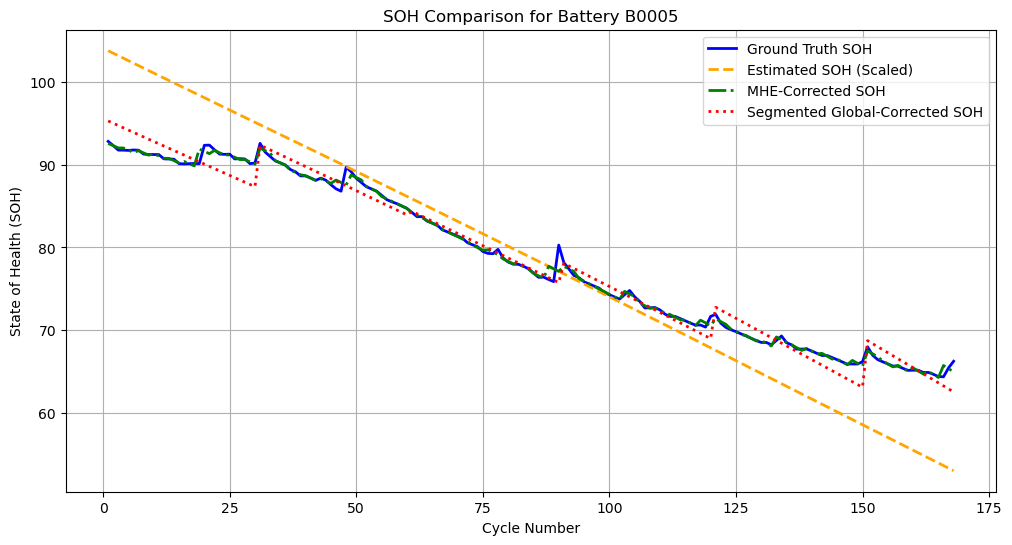

In [15]:
plot_soh_comparison(macro_df_mhe, battery_name, DATASET_FOLDER, segmented_df=macro_df_segmented)